<a href="https://colab.research.google.com/github/RamanVer1ma/AgroFarm/blob/main/CropHealthModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

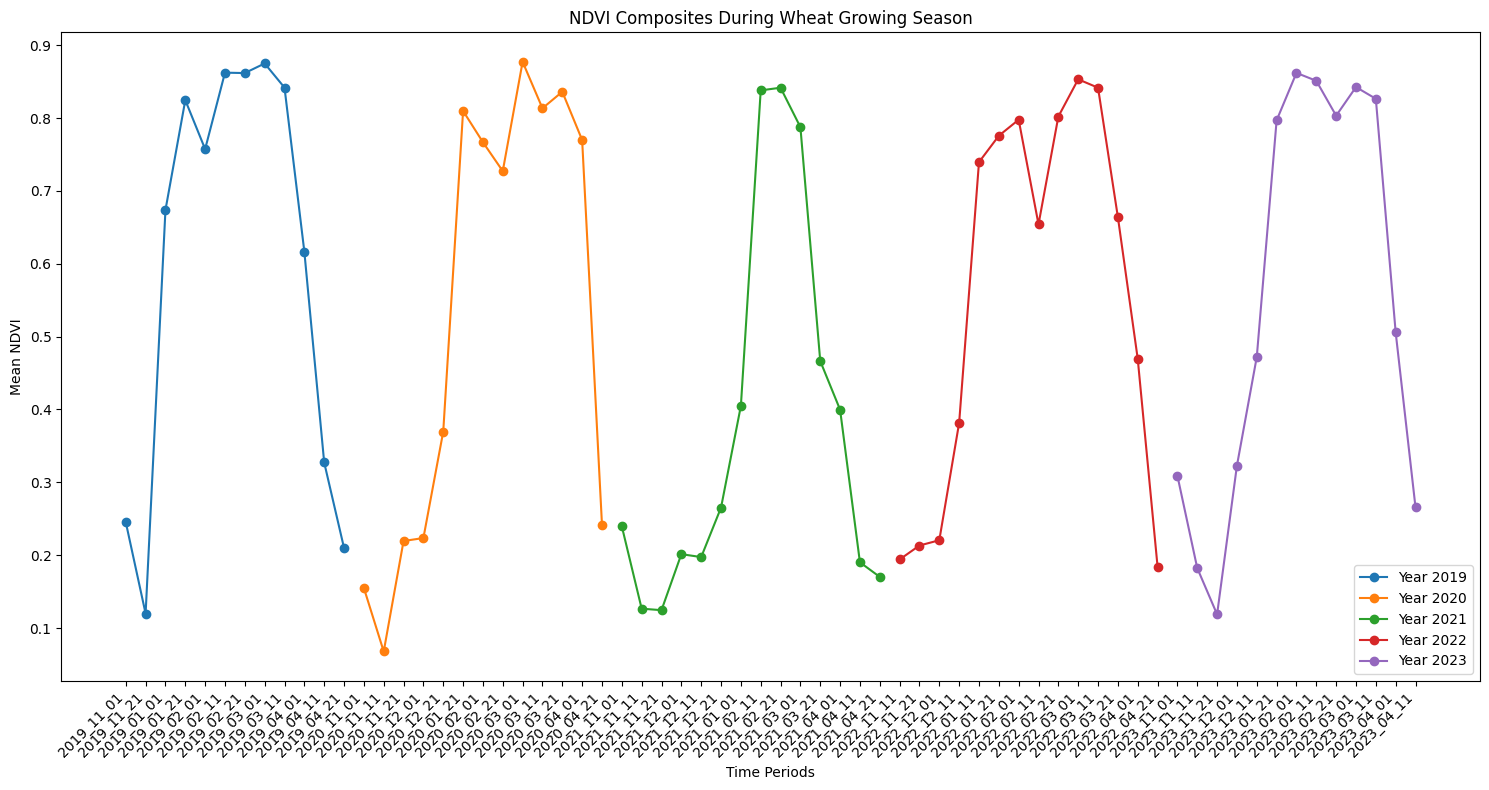

Missing periods: ['2019_11_11', '2019_12_01', '2019_12_11', '2019_12_21', '2019_01_11', '2019_03_21']
Missing periods: ['2020_12_11', '2020_01_01', '2020_01_11', '2020_02_11', '2020_04_11']
Missing periods: ['2021_01_11', '2021_01_21', '2021_02_01', '2021_03_11']
Missing periods: ['2022_11_01', '2022_12_21', '2022_01_01', '2022_04_11']
Missing periods: ['2023_12_21', '2023_01_01', '2023_01_11', '2023_03_21', '2023_04_21']


In [12]:
import ee
import geemap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

ee.Authenticate()
ee.Initialize(project = 'agrofram')

def create_date_ranges(year):
    """
    Create 5-10 day periods for wheat growing season
    Wheat sowing: Nov 1-15
    Wheat harvest: Feb-May
    """
    periods = []
    start_months = [11, 12, 1, 2, 3, 4]

    for month in start_months:
        for day_start in [1, 11, 21]:
            # Adjust year for January and February
            year_adjust = year if month not in [1, 2] else year + 1

            # Create start and end dates for 10-day periods
            start_date = ee.Date(f'{year if month >= 11 else year_adjust}-{month:02d}-{day_start:02d}')
            end_date = start_date.advance(10, 'day')

            periods.append({
                'start': start_date,
                'end': end_date,
                'label': f'{year}_{month:02d}_{day_start:02d}'
            })

    return periods

def load_and_process_ndvi(year, region):
    """
    Load Sentinel images and calculate NDVI composites for 5-10 day periods
    """
    # Get date ranges for the year
    periods = create_date_ranges(year)

    ndvi_composites = []

    for period in periods:
        # Load Sentinel-2 images for the period
        collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
            .filterDate(period['start'], period['end']) \
            .filterBounds(region) \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))

        # If no images, append None
        if collection.size().getInfo() == 0:
            ndvi_composites.append({
                'date': period['label'],
                'ndvi': None
            })
            continue

        # Calculate NDVI composite
        ndvi_composite = collection \
            .map(lambda image: image.normalizedDifference(['B8', 'B4']).rename('NDVI')) \
            .mean()

        # Extract mean NDVI value
        mean_ndvi = ndvi_composite.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=10,
            maxPixels=1e9
        ).get('NDVI').getInfo()

        ndvi_composites.append({
            'date': period['label'],
            'ndvi': mean_ndvi
        })

    return ndvi_composites

def plot_ndvi_composites(ndvi_data):
    """
    Plot NDVI composites across years
    """
    plt.figure(figsize=(15, 8))

    # Prepare data for plotting
    all_dates = []
    all_ndvis = []

    for year_data in ndvi_data:
        dates = [entry['date'] for entry in year_data if entry['ndvi'] is not None]
        ndvis = [entry['ndvi'] for entry in year_data if entry['ndvi'] is not None]

        plt.plot(dates, ndvis, marker='o', label=f'Year {dates[0][:4]}')

        all_dates.extend(dates)
        all_ndvis.extend(ndvis)

    plt.title('NDVI Composites During Wheat Growing Season')
    plt.xlabel('Time Periods')
    plt.ylabel('Mean NDVI')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return all_dates, all_ndvis

def main():
    # Define region of interest (example: Punjab, India)
    xmin, ymin = 75.84399, 30.81936
    xmax, ymax = 75.85511, 30.82714
    punjab = ee.Geometry.Rectangle([75.84399, 30.81936,75.85511, 30.82714])

    # Process NDVI for last 5 years
    ndvi_data = []
    for year in range(2019, 2024):
        year_ndvi = load_and_process_ndvi(year, punjab)
        ndvi_data.append(year_ndvi)

    # Plot NDVI composites
    dates, ndvis = plot_ndvi_composites(ndvi_data)

    # Print out details of missing data
    for year_data in ndvi_data:
        missing_periods = [entry['date'] for entry in year_data if entry['ndvi'] is None]
        if missing_periods:
            print(f"Missing periods: {missing_periods}")

if __name__ == '__main__':
    main()

In [13]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

ee.Authenticate()
ee.Initialize(project = 'agrofram')

def generate_full_timestamp_range(start_year, end_year):
    """
    Generate complete timestamp range for wheat growing season
    """
    timestamps = []
    for year in range(start_year, end_year + 1):
        # Wheat growing season from Nov to May
        current_date = datetime(year, 11, 1)
        season_end = datetime(year + 1, 5, 31)

        while current_date <= season_end:
            timestamps.append(current_date)
            current_date += timedelta(days=10)

    return timestamps

def load_ndvi_for_period(start_date, end_date, region):
    """
    Load Sentinel images and calculate NDVI for specific period
    """
    # Convert datetime to ee.Date
    start = ee.Date(start_date.strftime('%Y-%m-%d'))
    end = ee.Date(end_date.strftime('%Y-%m-%d'))

    # Load Sentinel-2 images
    collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterDate(start, end) \
        .filterBounds(region) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))

    # If no images, return None
    if collection.size().getInfo() == 0:
        return None

    # Calculate NDVI composite
    ndvi_composite = collection \
        .map(lambda image: image.normalizedDifference(['B8', 'B4']).rename('NDVI')) \
        .mean()

    # Extract mean NDVI value
    try:
        mean_ndvi = ndvi_composite.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=10,
            maxPixels=1e9
        ).get('NDVI').getInfo()
        return mean_ndvi
    except:
        return None

def create_ndvi_dataset(start_year, end_year):
    """
    Create comprehensive NDVI dataset
    """
  # Define region of interest (example: Punjab, India)
    xmin, ymin = 75.84399, 30.81936
    xmax, ymax = 75.85511, 30.82714
    punjab = ee.Geometry.Rectangle([75.84399, 30.81936,75.85511, 30.82714])


    # Generate full timestamp range
    timestamps = generate_full_timestamp_range(start_year, end_year)

    # Prepare data collection
    data = []
    for timestamp in timestamps:
        # 10-day period
        period_end = timestamp + timedelta(days=10)

        # Calculate NDVI
        ndvi = load_ndvi_for_period(timestamp, period_end, punjab)

        data.append({
            'timestamp': timestamp,
            'NDVIi': ndvi
        })

    # Convert to DataFrame
    df = pd.DataFrame(data)
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month

    return df

def plot_ndvi_dataset(df):
    """
    Plot NDVI dataset with missing values highlighted
    """
    plt.figure(figsize=(15, 8))

    # Group by year and plot
    for year in df['year'].unique():
        year_data = df[df['year'] == year]

        # Plot available NDVI values
        available = year_data[year_data['NDVIi'].notna()]
        plt.plot(available['timestamp'], available['NDVIi'],
                 marker='o', linestyle='-', label=f'Year {year}')

        # Highlight missing values
        missing = year_data[year_data['NDVIi'].isna()]
        if not missing.empty:
            plt.scatter(missing['timestamp'], [0]*len(missing),
                        color='red', marker='x', s=100)

    plt.title('NDVI Time Series with Missing Periods')
    plt.xlabel('Timestamp')
    plt.ylabel('NDVI Value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return df

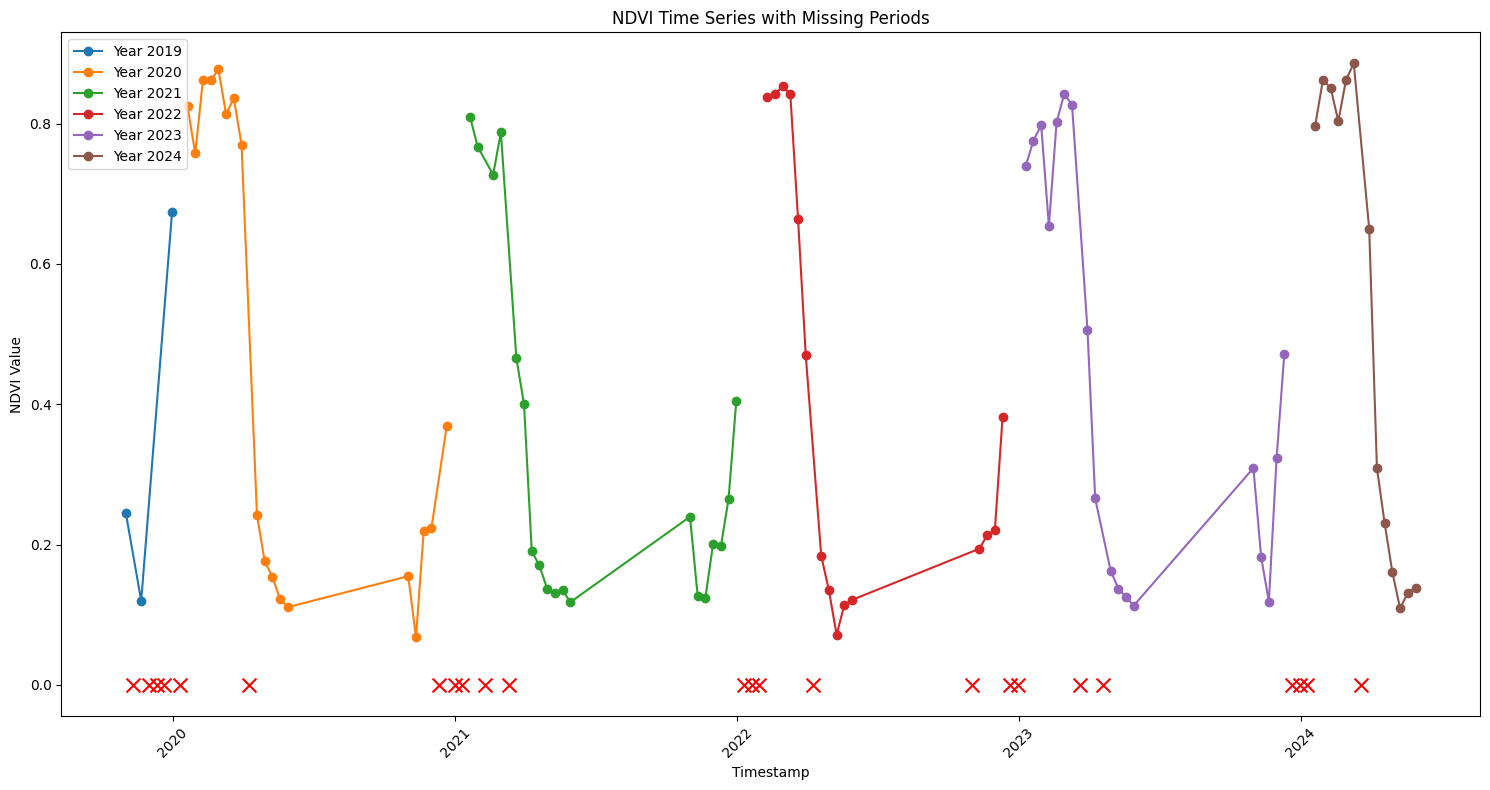

Missing NDVI Periods:
     timestamp  year  month
1   2019-11-11  2019     11
3   2019-12-01  2019     12
4   2019-12-11  2019     12
5   2019-12-21  2019     12
7   2020-01-10  2020      1
16  2020-04-09  2020      4
26  2020-12-11  2020     12
28  2020-12-31  2020     12
29  2021-01-10  2021      1
32  2021-02-09  2021      2
35  2021-03-11  2021      3
51  2022-01-10  2022      1
52  2022-01-20  2022      1
53  2022-01-30  2022      1
60  2022-04-10  2022      4
66  2022-11-01  2022     11
71  2022-12-21  2022     12
72  2022-12-31  2022     12
80  2023-03-21  2023      3
83  2023-04-20  2023      4
93  2023-12-21  2023     12
94  2023-12-31  2023     12
95  2024-01-10  2024      1
102 2024-03-20  2024      3


In [14]:

 # Generate NDVI dataset
ndvi_df = create_ndvi_dataset(2019, 2023)

    # Plot and display results
result_df = plot_ndvi_dataset(ndvi_df)

    # Print summary of missing data
missing_summary = result_df[result_df['NDVIi'].isna()]
print("Missing NDVI Periods:")
print(missing_summary[['timestamp', 'year', 'month']])



In [21]:
result_df

,timestamp,NDVIi,year,month
0,2019-11-01,0.245383,2019,11
1,2019-11-11,NaN,2019,11
2,2019-11-21,0.119827,2019,11
3,2019-12-01,NaN,2019,12
4,2019-12-11,NaN,2019,12
...,...,...,...,...
105,2024-04-19,0.230392,2024,4
106,2024-04-29,0.160804,2024,4
107,2024-05-09,0.109115,2024,5
108,2024-05-19,0.131149,2024,5


In [26]:
print(result_df['NDVIi'].isna().sum())

24


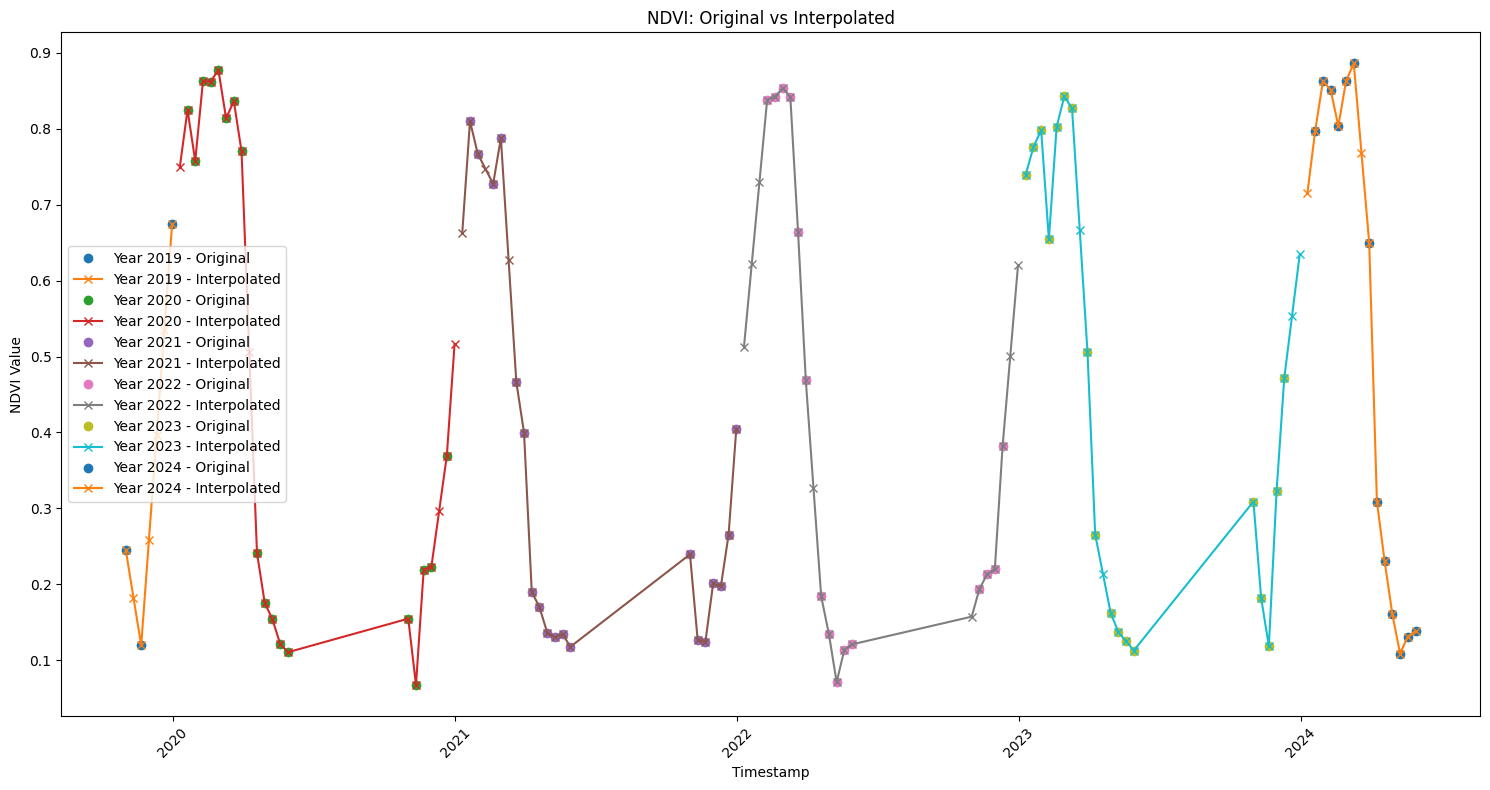

Missing values after interpolation: 0


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def interpolate_ndvi(df):

    df_interpolated = df.copy()

    # Linear Interpolation with forward and backward fill
    df_interpolated['NDVIi_interpolated'] = df_interpolated['NDVIi'].interpolate(
        method='linear',
        limit_direction='both'  # Allow interpolation in both directions
    )

    # Fill any remaining NaNs with seasonal median
    df_interpolated['month_period'] = df_interpolated['timestamp'].dt.month.astype(str) + '_' + \
                                       (df_interpolated['timestamp'].dt.day // 10).astype(str)

    for month_period in df_interpolated['month_period'].unique():
        period_mask = df_interpolated['month_period'] == month_period
        median_value = df_interpolated[period_mask]['NDVIi_interpolated'].median()

        fill_mask = period_mask & df_interpolated['NDVIi_interpolated'].isna()
        df_interpolated.loc[fill_mask, 'NDVIi_interpolated'] = median_value

    # Visualization
    plt.figure(figsize=(15, 8))

    # Original and Interpolated Data
    years = df_interpolated['year'].unique()
    for year in years:
        year_data = df_interpolated[df_interpolated['year'] == year]

        plt.plot(year_data['timestamp'], year_data['NDVIi'],
                 marker='o', linestyle='', label=f'Year {year} - Original')
        plt.plot(year_data['timestamp'], year_data['NDVIi_interpolated'],
                 marker='x', linestyle='-', label=f'Year {year} - Interpolated')

    plt.title('NDVI: Original vs Interpolated')
    plt.xlabel('Timestamp')
    plt.ylabel('NDVI Value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return df_interpolated

result = interpolate_ndvi(result_df)
print("Missing values after interpolation:", result['NDVIi_interpolated'].isna().sum())

In [32]:
print(result['NDVIi_interpolated'].isna())

0      False
1      False
2      False
3      False
4      False
       ...  
105    False
106    False
107    False
108    False
109    False
Name: NDVIi_interpolated, Length: 110, dtype: bool


In [33]:
print(result)

     timestamp     NDVIi  year  month  NDVIi_interpolated month_period
0   2019-11-01  0.245383  2019     11            0.245383         11_0
1   2019-11-11       NaN  2019     11            0.182605         11_1
2   2019-11-21  0.119827  2019     11            0.119827         11_2
3   2019-12-01       NaN  2019     12            0.258313         12_0
4   2019-12-11       NaN  2019     12            0.396800         12_1
..         ...       ...   ...    ...                 ...          ...
105 2024-04-19  0.230392  2024      4            0.230392          4_1
106 2024-04-29  0.160804  2024      4            0.160804          4_2
107 2024-05-09  0.109115  2024      5            0.109115          5_0
108 2024-05-19  0.131149  2024      5            0.131149          5_1
109 2024-05-29  0.138777  2024      5            0.138777          5_2

[110 rows x 6 columns]


In [39]:
result = result.drop(columns= ['month_period'])
result = result.drop(columns= ['NDVIi'])
print(result)

     timestamp  year  month  NDVIi_interpolated
0   2019-11-01  2019     11            0.245383
2   2019-11-21  2019     11            0.119827
6   2019-12-31  2019     12            0.673772
8   2020-01-20  2020      1            0.824572
9   2020-01-30  2020      1            0.757395
..         ...   ...    ...                 ...
105 2024-04-19  2024      4            0.230392
106 2024-04-29  2024      4            0.160804
107 2024-05-09  2024      5            0.109115
108 2024-05-19  2024      5            0.131149
109 2024-05-29  2024      5            0.138777

[86 rows x 4 columns]


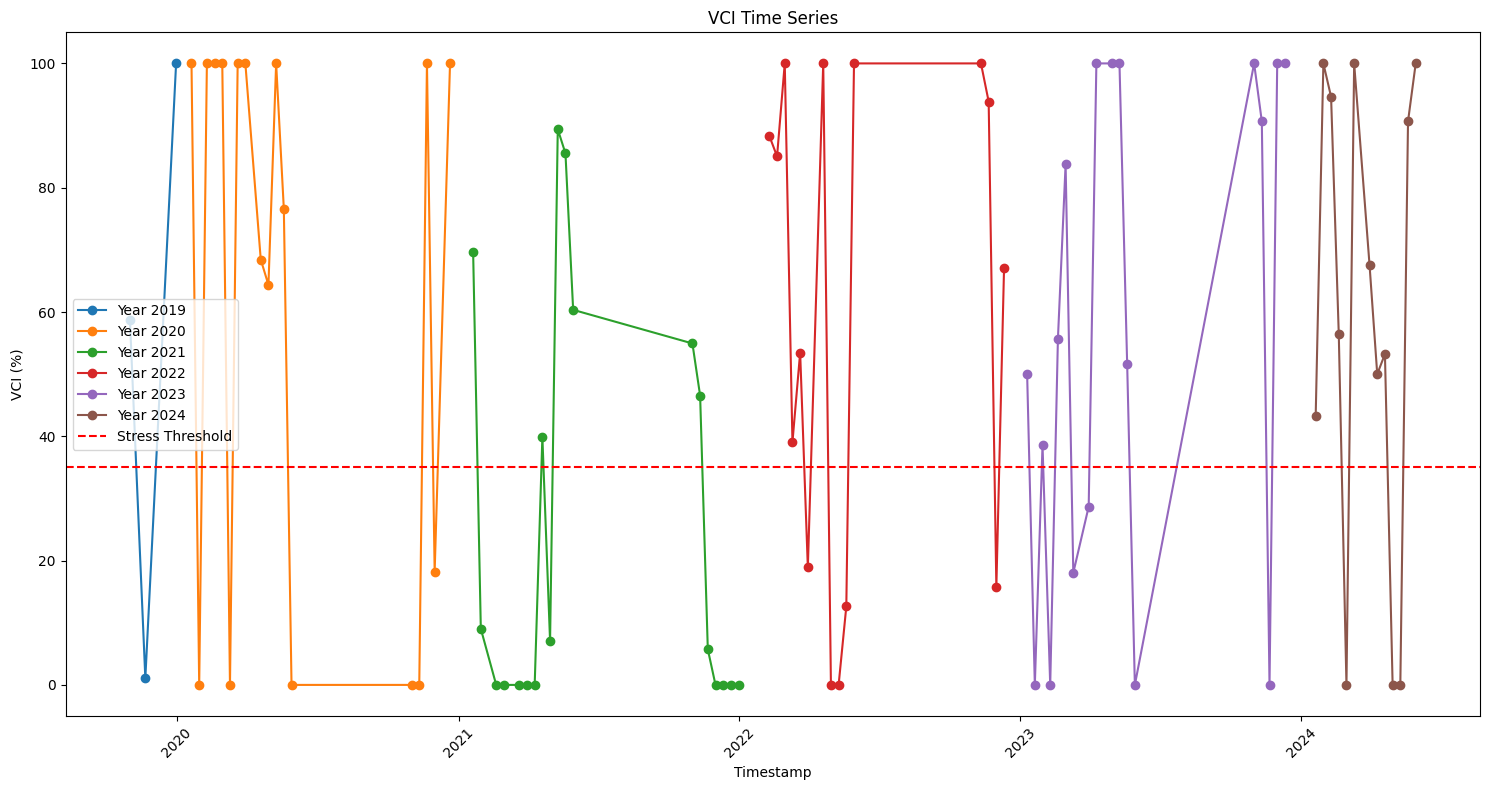


VCI Statistics:
      count       mean        std       min        25%        50%         75%  \
year                                                                            
2019    3.0  53.247714  49.688201  1.069051  29.871571  58.674091   79.337046   
2020   18.0  62.645611  44.973410  0.000000   4.557178  88.293494  100.000000   
2021   19.0  24.642612  32.671344  0.000000   0.000000   5.734461   50.749216   
2022   15.0  58.270802  40.139902  0.000000  17.315722  67.068798   96.931112   
2023   18.0  56.501266  41.070364  0.000000  20.704936  53.643218  100.000000   
2024   13.0  58.142624  38.934639  0.000000  43.248071  56.503579   94.630412   

             max  
year              
2019  100.000000  
2020  100.000000  
2021   89.411925  
2022  100.000000  
2023  100.000000  
2024  100.000000  


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def calculate_vci(df):
    df['month_period'] = df['timestamp'].dt.month.astype(str) + '_' + \
                        (df['timestamp'].dt.day // 10).astype(str)

    period_stats = df.groupby('month_period')['NDVIi_interpolated'].agg(['min', 'max'])

    def compute_vci(row):
        period = row['month_period']
        ndvi_min = period_stats.loc[period, 'min']
        ndvi_max = period_stats.loc[period, 'max']

        # Handle cases where max equals min
        if ndvi_max == ndvi_min:
            return 50  # Assign middle value when no variation
        return (row['NDVIi_interpolated'] - ndvi_min) / (ndvi_max - ndvi_min) * 100

    df['VCI'] = df.apply(compute_vci, axis=1)

    # Visualization
    plt.figure(figsize=(15, 8))
    for year in df['year'].unique():
        year_data = df[df['year'] == year]
        plt.plot(year_data['timestamp'], year_data['VCI'], marker='o', label=f'Year {year}')

    plt.title('VCI Time Series')
    plt.xlabel('Timestamp')
    plt.ylabel('VCI (%)')
    plt.axhline(y=35, color='r', linestyle='--', label='Stress Threshold')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return df

result_vci = calculate_vci(result)

# Display summary statistics
print("\nVCI Statistics:")
print(result_vci.groupby('year')['VCI'].describe())